# Preprocess Data from Preprocessing file

In [18]:
import os
from Preprocessing import preprocess_data
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

my_dir = os.getcwd()
print(f"Current working directory: {my_dir}")

# change this accordingly but should work for all users
glioma_path = my_dir[:-15] + "/data/glioma_tumor"
meningioma_path = my_dir[:-15] + "/data/meningioma_tumor"
pituitary_path = my_dir[:-15] + "/data/pituitary_tumor"
normal_path = my_dir[:-15] + "/data/normal_tumor"


# preprocess data
n_samples = 200 # good starting point to train model
seed = 42 # reproducibility
glioma_data, glioma_labels = preprocess_data(glioma_path, n_samples, seed)
meningioma_data, meningioma_labels = preprocess_data(meningioma_path, n_samples, seed)
pituitary_data, pituitary_labels = preprocess_data(pituitary_path, n_samples, seed)
normal_data, normal_labels = preprocess_data(normal_path, n_samples, seed)
if glioma_data.shape != meningioma_data.shape or pituitary_data.shape != normal_data.shape:
    raise ValueError("All data must have the same shape")
else:
    print("All data have the same shape")

# combine all data and labels
data = np.concatenate([glioma_data, meningioma_data, pituitary_data, normal_data])
labels = np.concatenate([glioma_labels, meningioma_labels, pituitary_labels, normal_labels])
print(f"Combined data and labels shape: {data.shape}, {labels.shape}")

# split data into training and testing and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_small, val_data, train_small_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# one hot encode labels
label_encoder = OneHotEncoder(sparse=False)
train_labels = label_encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
test_labels = label_encoder.transform(np.array(test_labels).reshape(-1, 1))
train_small_labels = label_encoder.transform(np.array(train_small_labels).reshape(-1, 1))
val_labels = label_encoder.transform(np.array(val_labels).reshape(-1, 1))

Current working directory: /Users/caseylinden/Documents/PSTAT197A/GitHub/vignette-cnn/scripts/drafts
All data have the same shape
Combined data and labels shape: (800, 256, 256, 1), (800,)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Visually Inspect

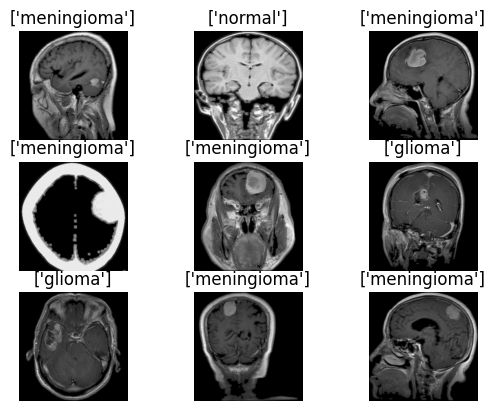

In [14]:
# inverse transform labels
labels = label_encoder.inverse_transform(train_labels)

# show images from training set
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_data[i], cmap="gray")
    plt.axis('off')
    plt.title((labels[i]))
plt.show()

# Modeling
- We first can start with a simple convolution model to see how well a few different architectures will pick up on the training data set,
- Then we will apply a hyperparameter tuning technique, called Hyperband tuning, to find the best setup.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras

2024-12-02 15:02:28.699348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Simple CNN to Start
### Model Flow
- In our example, the filters will pickup on different shapes, edges, and other patterns in the image, by sliding multiple 3x3 kernels convolving with the input image.
- After this we, apply a pooling function of either averaging or maximizing which typically halves the size of our convolved feature.
- Then after another round of convolving and maxpool, we flatten it and pass to a Dense neural network of hidden layers
- Finally the output layer is activated by a softmax function to provide us with probabilities of the classes. 

In [19]:
# Initialize model
model = Sequential()

# Convolutional layer + pooling
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 1))) # 3x3 is the kernel size, 32 is the number of filters
model.add(MaxPooling2D(2))

# Add another convolutional layer + pooling
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2))

# Flatten 3D feature maps into 1D feature vectors
model.add(Flatten())

# Fully connected layer
model.add(Dense(units=128, activation='relu'))

# Dropout to prevent overfitting
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 246016)            0         
                                                                 
 dense_4 (Dense)             (None, 128)              

# Training the model

Epoch 1/20
15/15 [==============================] - 22s 1s/step - loss: 1.3585 - accuracy: 0.3812 - val_loss: 1.3317 - val_accuracy: 0.3938
Epoch 2/20
15/15 [==============================] - 21s 1s/step - loss: 1.2586 - accuracy: 0.4542 - val_loss: 1.1367 - val_accuracy: 0.5562
Epoch 3/20
15/15 [==============================] - 22s 1s/step - loss: 1.0813 - accuracy: 0.5562 - val_loss: 1.2698 - val_accuracy: 0.3750
Epoch 4/20
15/15 [==============================] - 21s 1s/step - loss: 0.9289 - accuracy: 0.6208 - val_loss: 0.8987 - val_accuracy: 0.7250
Epoch 5/20
15/15 [==============================] - 21s 1s/step - loss: 0.7455 - accuracy: 0.7167 - val_loss: 0.7967 - val_accuracy: 0.7125
Epoch 6/20
15/15 [==============================] - 22s 1s/step - loss: 0.5578 - accuracy: 0.7958 - val_loss: 0.7573 - val_accuracy: 0.7250
Epoch 7/20
15/15 [==============================] - 21s 1s/step - loss: 0.3978 - accuracy: 0.8583 - val_loss: 0.7892 - val_accuracy: 0.7000
Epoch 8/20
15/15 [==

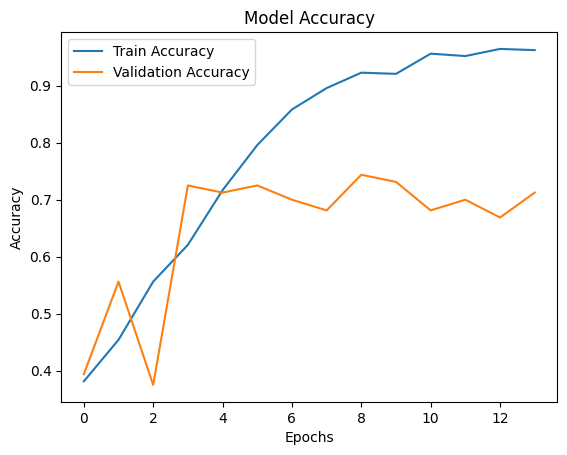

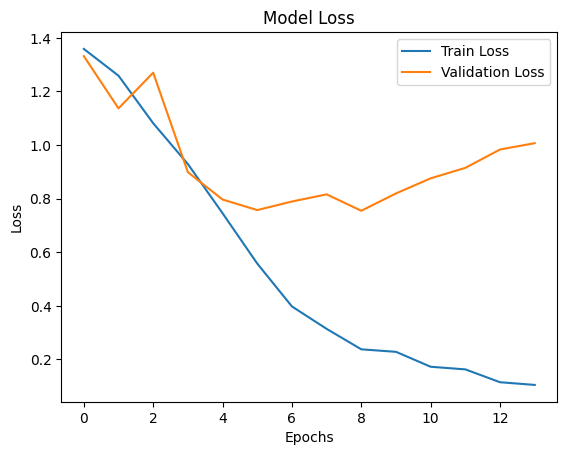

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model

# Early stopping will stop training when the validation loss stops improving for a few epochs, preventing overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_small,
    train_small_labels,
    validation_data=(val_data, val_labels), # Convert sparse matrix
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# TODO LATER once decent performance on simple CNN:
HyperParameter Tuning
- Using Hyperband from kerastuners, we can define a function to build the best model.
- After finding the best model, we can then build a new model to train.

In [2]:
# building a hyperband model to find the best model architecture
import kerastuner as kt
from kerastuner.tuners import Hyperband
def build_model(hp):
    '''Hyperband function to test different model architectures'''
    model = Sequential()
    model.add(Conv2D(units=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16), # find the best number of filters
                     kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
                     activation='relu'), input_shape=(256, 256))
    model.add(MaxPooling2D(2)) # max pooling to reduce the dimensionality of the data
    model.add(Conv2D(units=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16), # find the best number of filters
                     kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
                     activation='relu'))
    model.add(MaxPooling2D(2)) # max pooling to reduce the dimensionality of the data
    model.add(Flatten()) # flatten the data to feed into the dense layers
    model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16), # find the best number of units
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1))) # dropout to prevent overfitting
    model.add(Dense(4, activation='softmax')) # pituitary, meningioma, glioma, normal
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), # find the best learning rate
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model